In [1]:
import os
import time
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from skimage.transform import resize
from skimage import feature
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
annotations_dir = r"D:\Studying\Personal_Project\Computer Vision\TrafficSign Detection\Data\traffic_sign_detection\annotations"
images_dir = r"D:\Studying\Personal_Project\Computer Vision\TrafficSign Detection\Data\traffic_sign_detection\images"

img_list = []
label_list = []

In [3]:
for xml_file in os.listdir(annotations_dir):
    xml_path = os.path.join(annotations_dir, xml_file)

    tree = ET.parse(xml_path)
    root = tree.getroot()

    folder = root.find('folder').text
    img_filename = root.find('filename').text
    img_filepath = os.path.join(images_dir, img_filename)
    img = cv2.imread(img_filepath)

    for obj in root.findall('object'):
        classname = obj.find('name').text
        if classname == 'trafficlight':
            continue

        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        object_img = img[ymin:ymax, xmin:xmax]
        img_list.append(object_img)
        label_list.append(classname)

In [4]:
len(img_list), len(label_list), set(label_list)

(1074, 1074, {'crosswalk', 'speedlimit', 'stop'})

In [5]:
def processing_img(img):
    if len(img.shape) > 2:
        img = cv2.cvtColor(
            img, 
            cv2.COLOR_BGR2GRAY
        )
    
    img = img.astype(np.float32)

    resized_img = resize(
        img,
        output_shape= (32,32),
        anti_aliasing= True
    )

    hog_feature = feature.hog(
        resized_img,
        orientations= 9,
        pixels_per_cell= (8,8),
        cells_per_block= (2,2),
        transform_sqrt= True,
        block_norm= 'L2',
        feature_vector= True
    )

    return hog_feature

In [6]:
img_features_list = []
for img in img_list:
    hog_feature = processing_img(img)
    img_features_list.append(hog_feature)

img_features = np.array(img_features_list)

In [7]:
img_features.shape

(1074, 324)

In [8]:
label_encoder = LabelEncoder()
encode_labels = label_encoder.fit_transform(label_list)

In [9]:
test_size = 0.3
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_features, encode_labels,
    test_size= test_size,
    random_state= 0,
    shuffle= False
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [39]:
classifier = SVC(
    kernel= 'rbf',
    probability= True,
    C= 0.9
)
classifier.fit(X_train, y_train)

SVC(C=0.9, probability=True)

In [40]:
y_pred = classifier.predict(X_val)
score = accuracy_score(y_pred, y_val)
score

0.9814241486068112

# Detect vị trí xem có tồn tại biển báo

## Tạo các cửa sổ trượt trên các bức ảnh để detect thủ công vị trí của các vật thể 

In [41]:
def sliding_window(img, window_sizes, stride, scale_factor):
    img_height, img_width = img.shape[:2]
    windows = []
    for window_size in window_sizes:
        window_height, window_width = window_size
        window_height = int(window_height * scale_factor)
        window_width = int(window_width * scale_factor)
        
        for ymin in range(0, img_height - window_height + 1, stride):
            for xmin in range(0, img_width - window_width + 1, stride):
                xmax = xmin + window_width
                ymax = ymin + window_height

                windows.append([xmin,ymin,xmax,ymax])
    return windows    

## Sử dụng kỹ thuật thu/phóng ảnh để xác định các vật thể bé 

In [42]:
def pyramid(img, scale= 0.8, min_size= (30,30)):
    acc_scale = 1.0
    pyramid_img = [(img, acc_scale)]

    while True:
        acc_scale = acc_scale * scale
        h = int(img.shape[0] * acc_scale)
        w = int(img.shape[1] * acc_scale)

        if h < min_size[0] or w < min_size[1]:
            break
        img = cv2.resize(img, (w, h))
        pyramid_img.append((img, acc_scale))

    return pyramid_img
        

## Hiển thị các hình ảnh của các bndbox

In [43]:
def visualization(img, bboxes, label_encoder):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for box in bboxes:
        xmin, ymin, xmax, ymax, predict_id, conf_score = box

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0,255,0), 1)

        classname = label_encoder.inverse_transform([predict_id])[0]
        label = f"{classname}:{conf_score:.2f}"

        (w,h),_ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)

        cv2.rectangle(img, (xmin, ymin-20), (xmin+w, ymin), (0,255,0), -1)
        cv2.putText(img, label, (xmin, ymin-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6,(0,0,0), 1)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Pipe

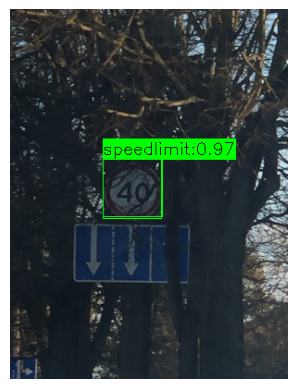

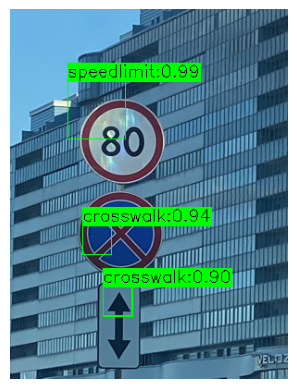

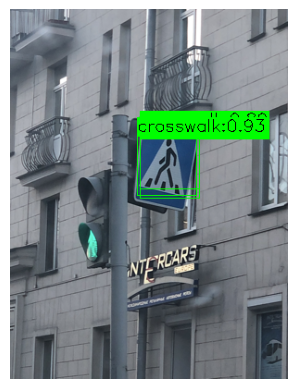

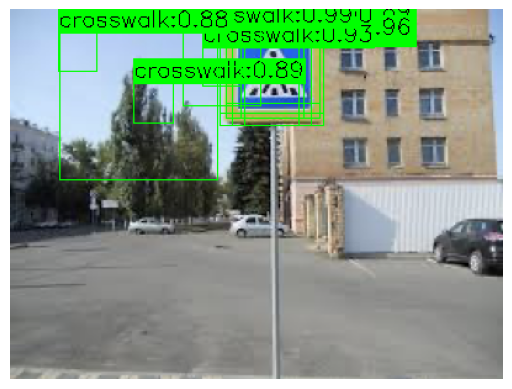

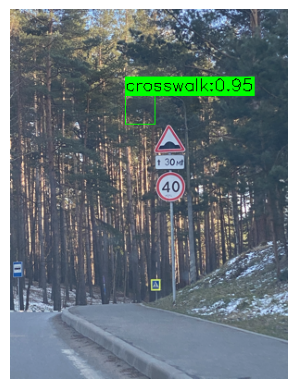

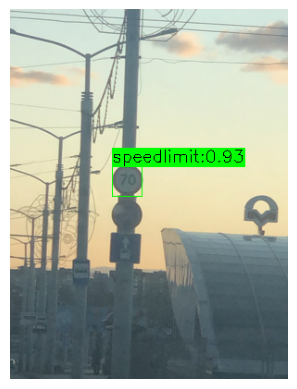

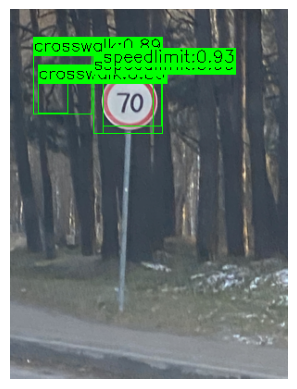

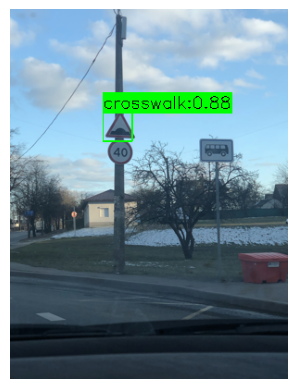

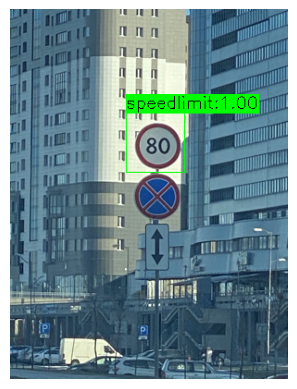

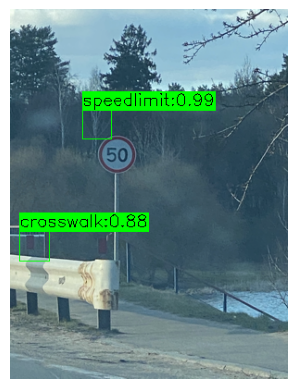

In [46]:
img_dir = 'D:\Studying\Personal_Project\Computer Vision\TrafficSign Detection\Data\traffic_sign_detection\images'
img_filename_list = os.listdir(img_dir)[10:20]
conf_threshold = 0.88
stride = 10
window_sizes = [(32,32), (128,128), (64,64)]

for img_filename in img_filename_list:
    img_path = os.path.join(img_dir, img_filename)
    bboxes = []
    img = cv2.imread(img_path)
    pyramid_imgs = pyramid(img)
    
    for pyramid_img_infor in pyramid_imgs:
        pyramid_img, scale = pyramid_img_infor
        window_list = sliding_window(
            pyramid_img, 
            window_sizes= window_sizes,
            stride= stride,
            scale_factor= scale
        )
        for window in window_list:
            xmin, ymin, xmax, ymax = window
            object_img = pyramid_img[ymin:ymax, xmin:xmax]
            processed_img = processing_img(object_img)
            normalized_img = scaler.transform([processed_img])
            decision = classifier.predict_proba(normalized_img)[0]
            
            if np.all(decision < conf_threshold):
                continue
            else:
                 predict_id = np.argmax(decision)
                 conf_score = decision[predict_id]
                 xmin = int(xmin / scale)
                 ymin = int(ymin / scale)
                 xmax = int(xmax / scale)
                 ymax = int(ymax / scale)
                 bboxes.append([xmin, ymin, xmax, ymax, predict_id, conf_score])
    
    visualization(img, bboxes, label_encoder)